<a href="https://colab.research.google.com/github/ElahehSadeghabadi/E2E-Communication-based-on-Deep-Learning/blob/main/4_MIMO_for_Multiplexing_Gain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2025 ElahehSadeghabadi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Point-to-Point, $2\times 2$ MIMO with block fading and with CSIT and CSIR to achieve spatial multiplexing from the following paper:**

[2] T. J. O'Shea, T. Erpek and T. C. Clancy, "*Physical layer deep learning of encodings for the MIMO fading channel,*" 2017 55th Annual Allerton Conference on Communication, Control, and Computing (Allerton), Monticello, IL, USA, 2017, pp. 76-80.

# Setup

In [ ]:
import numpy as np
import tensorflow as tf
from math import ceil, log

# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Resetting the name counters
tf.keras.backend.clear_session()

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from IPython.display import Image, display

# System Model

Consider a point-to-point $2\times 2$ MIMO system:
  - The two messages $s_1,s_2\in\mathcal{M}$ are sent at one point and the messages $\hat{s}_1,\hat{s}_2\in\mathcal{M}$ are detected at the other point.
  - Each message has $k$ information bit: $|\mathcal{M}|=M=2^k$.
  - The transmitter has $m_\rm{Tx}=2$ antennas, and the receiver has $m_\rm{Rx}=2$ antennas.
  - The codeword includes $m_\rm{Tx}$ parallel transmissions in each of $n$ channel uses, and it is represented by $\mathbf{x}=\left[\mathbf{x}_1^T,\dots,\mathbf{x}_n^T\right]^T$, where $\mathbf{x}\in\mathbb{C}^{nm_\rm{Tx}}$ and $\mathbf{x}_i\in\mathbb{C}^{m_\rm{Tx}},\forall i=1,\dots,n$.
  - The received signal includes $n$ received signals by $m_\rm{Rx}$ antennas, and it is represented by $\mathbf{y}=\left[\mathbf{y}_1,\dots,\mathbf{y}_n\right]^T$, where $\mathbf{y}\in\mathbb{C}^{nm_\rm{Rx}}$ and $\mathbf{y}_i\in\mathbb{C}^{m_\rm{Rx}},\forall i=1,\dots,n$.
  - The encoder maps the messages $s_1,s_2\in\mathcal{M}$ to the codeword $\mathbf{x}$, and the decoder maps the received signal $\mathbf{y}$ to the messages $\hat{s}_1,\hat{s}_2\in\mathcal{M}$.
  - The channel matrix $\mathbf{H}\in\mathbb{C}^{m_\rm{Tx}\times m_\rm{Rx}}$ is assumed **quasi-static**, which means that the channel matrix is constant during each codeword transmission (including $n$ channel uses) and changes for the next codeword by Rayleigh distribution.
  - There are perfect CSIR and CSIT.

The system model considered by the paper is represented in Fig. 1.

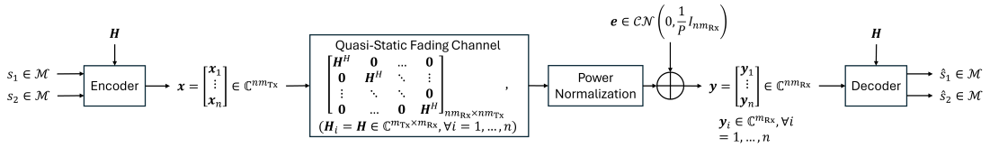

Figure 1: The system model of P2P MIMO system considered in [2, closed-loop model], where equal power is used at each antenna during transmission, i.e., $\mathbb{E}\left\{\left|x_{i,1}\right|^2\right\}=\dots=\mathbb{E}\left\{\left|x_{i,m_\rm{Tx}}\right|^2\right\},\forall i = 1,\dots,n$, and the power normalization is applied after the fading channel.

**Note:** In this model, the power normalization is placed after the fading block. However, this consideration seems unrealistic, because power normalization is a transmitter constraint. Probably, the paper ueses a mathematical trick to ensure the gradient can be passed back through the channel and that the loss function operates on a consistent signal power regardless of the channel gain $\mathbf{H}$. Hence, in the following, The system model in Fig. 2 is simulated, where the power normalization is applied as a transmitter constraint. The signal-to-noise ratio (SNR) in this system is $P$, and the power limit for transmission in a channel use is 1.

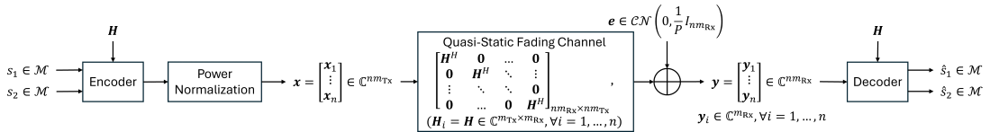

Figure 2: The system model of P2P MIMO system, where the power normalization is applied as a transmitter constraint ensuring $\mathbb{E}\left\{\left\|\mathbf{x}_i\right\|^2\right\}\leq 1,\forall i = 1,\dots,n$.

## Deep Learning-Based Model

The details of the Encoder and Decoder NNs are not mentioned in [2]. The following architecture in Tables 1 and 2 are applied here.

**Table 1: Encoder Neural Network of P2P $2\times 2$ MIMO for Encoding Two Streams**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Message 1 Input (one-hot encoding)|$M$|-|
|Message 2 Input (one-hot encoding)|$M$|-|
|CSIT Input (Real float numbers)|$2m_{\rm{Tx}}m_{\rm{Rx}}$|-|
|Dense|$128$|`relu`|
|Dense|$128$|`relu`|
|Dense|$2nm_\rm{Tx}$|`linear`|
|Normalization (transmitter constraint)|$2nm_\rm{Tx}$|-|


**Table 2: Decoder Neural Network of P2P $2\times 2$ MIMO for Decoding Two Streams**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Received Signal Input (Real float numbers)|$2nm_\rm{Rx}$|-|
|CSIR Input (Real float numbers)|$2m_{\rm{Tx}}m_{\rm{Rx}}$|-|
|Dense|$128$|`relu`|
|Dense|$128$|`relu`|
|Output1: Estimated Message 1|$M$|`softmax`|
|Output2: Estimated Message 2|$M$|`softmax`|

**Note:** The factor 2 in Tables 1 and 2 refers to complex signaling. Each complex number includes 2 real numbers.

The training parameters applied here are summarized in Table 3:

**Table 3: Training Parameters**  
|Training SNR  in dB|Number of Samples|Epochs|Batch Size|Optimizer|
|:-----------------:|:---------------:|:----:|:--------:|:-------:|
|20|100_000|30|1024|`AdamW(learning_rate=0.001)`|

# Creating and Training Models by TensorFlow and Keras

Before going forward to creating models by TensorFlow and Keras, don't forget to run the methods for transmitter constraint and for applying fading channel!

## Normalization and Fading Channel Methods

In [ ]:
def apply_power_norm(x, power_lim = 1.0):

    # Power normalization:------------------------------------------------------
    # Applying power constraint of power_lim per transmission in a channel use
    avg_power = tf.reduce_mean(tf.square(x), axis=0)
    scale_factors = tf.where(avg_power > (power_lim/2),
                            tf.math.sqrt((power_lim/2) / avg_power),
                            tf.ones_like(avg_power))
    y = x * tf.expand_dims(scale_factors, axis=0)
    #---------------------------------------------------------------------------
    return y

In [ ]:
def apply_rayleigh(x):

    x1_real = x[...,:n]
    x1_complex = x[...,n:2*n]

    x2_real = x[...,2*n:3*n]
    x2_complex = x[..., 3*n:4*n]

    # Channel
    """
    The channel matrix is assumed to be constant during each codeword transmission and it changes for the next codeword by Rayleigh distribution.
    Rx1-Tx1: real: h[0], complex: h[1]
    Rx1-Tx2: real: h[2], complex: h[3]
    Rx2-Tx1: real: h[4], complex: h[5]
    Rx2-Tx2: real: h[6], complex: h[7]
    """
    h = x[...,4*n:]
    h11_real = tf.expand_dims(h[:,0],axis = 1)
    h11_complex = tf.expand_dims(h[:,1],axis = 1)
    h12_real = tf.expand_dims(h[:,2],axis = 1)
    h12_complex = tf.expand_dims(h[:,3],axis = 1)
    h21_real = tf.expand_dims(h[:,4],axis = 1)
    h21_complex = tf.expand_dims(h[:,5],axis = 1)
    h22_real = tf.expand_dims(h[:,6],axis = 1)
    h22_complex = tf.expand_dims(h[:,7],axis = 1)

    # Applying channel:---------------------------------------------------------
    # Rx Antenna 1 = h11 x1 + h12 x2
    y1_real = h11_real * x1_real - h11_complex * x1_complex + h12_real * x2_real - h12_complex * x2_complex
    y1_complex = h11_complex * x1_real + h11_real * x1_complex + h12_complex * x2_real + h12_real * x2_complex
    # Rx Antenna 2 = h21 x1 + h22 x2
    y2_real = h21_real * x1_real - h21_complex * x1_complex + h22_real * x2_real - h22_complex * x2_complex
    y2_complex = h21_complex * x1_real + h21_real * x1_complex + h22_complex * x2_real + h22_real * x2_complex
    #---------------------------------------------------------------------------
    return tf.concat([y1_real, y1_complex, y2_real, y2_complex], axis = -1)

## Creating and Training Tx and Rx Models

In [ ]:
def MIMO_2by2_multiplexing(n, k, training_SNR_dB = 20, n_samples = 100_000, epochs = 30, batch_size = 1024):
  # We assume complex signaling here.
  # As it is assumed that perfect CSIT and CSIR available, the model gives channel fading as input.

  tf.keras.backend.clear_session()# Resetting the name counters

  M = 2**k
  R = k/n
  power_limit = 1.0
  snr = 10**(training_SNR_dB/10)
  noise_std = np.sqrt(0.5/snr)
  # Messages====================================================================
  m_tx = 2
  m_rx = 2

  # Channel
  H = tf.random.normal(shape = [n_samples,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)

  # Message indexing:
  messages1 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)
  messages2 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)

  # One-hot encoding:
  X_train1 = tf.one_hot(messages1, M)# messages in the first input of Tx
  X_train2 = tf.one_hot(messages2, M)# messages in the second input of Tx

  # Creating the model==========================================================
  # Tx--------------------------------------------------------------------------
  tx_input1 = tf.keras.layers.Input(shape=[M,]) # Input1
  tx_input2 = tf.keras.layers.Input(shape=[M,]) # Input2
  channel_input = tf.keras.layers.Input(shape=[m_tx*m_rx*2,]) # channel
  tx_input = tf.keras.layers.Concatenate()([tx_input1, tx_input2, channel_input])

  tx_output = tf.keras.layers.Dense(128, activation='relu')(tx_input)
  tx_output = tf.keras.layers.Dense(128, activation='relu')(tx_output)
  tx_output = tf.keras.layers.Dense(2*m_tx*n)(tx_output)
  tx_output = tf.keras.layers.Lambda(lambda x: apply_power_norm(x, power_lim = power_limit), output_shape=(2*m_tx*n,))(tx_output)

  tx_model = tf.keras.Model(inputs=[tx_input1, tx_input2, channel_input], outputs=tx_output)

  # Reyleigh channel and normalization------------------------------------------
  reyleigh_input = tf.keras.layers.Concatenate()([tx_output, channel_input])
  reyleigh_output = tf.keras.layers.Lambda(lambda x: apply_rayleigh(x), output_shape=(2*m_rx*n,))(reyleigh_input)

  ch_reyleigh = tf.keras.Model(inputs = [tx_output, channel_input], outputs = reyleigh_output)

  # AWGN------------------------------------------------------------------------
  ch_out = tf.keras.layers.GaussianNoise(noise_std)(reyleigh_output)

  # Rx--------------------------------------------------------------------------
  rx_input = tf.keras.layers.Concatenate()([ch_out, channel_input])
  rx_output = tf.keras.layers.Dense(128, activation='relu')(rx_input)
  rx_output = tf.keras.layers.Dense(128, activation='relu')(rx_output)
  rx_output1 = tf.keras.layers.Dense(M, activation='softmax')(rx_output)
  rx_output2 = tf.keras.layers.Dense(M, activation='softmax')(rx_output)

  rx_model = tf.keras.Model(inputs=[ch_out, channel_input], outputs=[rx_output1, rx_output2])

  # E2E model-------------------------------------------------------------------
  e2e_model = tf.keras.Model(inputs=[tx_input1, tx_input2, channel_input], outputs=[rx_output1, rx_output2])
  # Compiling===================================================================
  e2e_model.compile(loss = ["categorical_crossentropy","categorical_crossentropy"], optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001))
  # Training====================================================================
  e2e_model.fit((X_train1,X_train2,H),(X_train1,X_train2), epochs = epochs, batch_size = batch_size)
  return tx_model, ch_reyleigh, rx_model

# Evaluating

## BER

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - dense_5_loss: 1.1788 - dense_6_loss: 1.2740 - loss: 2.4528
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.3663 - dense_6_loss: 0.7017 - loss: 1.0680
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.2106 - dense_6_loss: 0.2657 - loss: 0.4763
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.0800 - dense_6_loss: 0.0949 - loss: 0.1749
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - dense_5_loss: 0.0418 - dense_6_loss: 0.0473 - loss: 0.0891
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.0277 - dense_6_loss: 0.0305 - loss: 0.0582
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.0212 - dense_6_loss: 0.0233 - loss: 0.0444
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.0189 - dense_6_loss: 0.0194 - loss: 0.0383
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_5_loss: 0.0150 - dense_6_loss: 0.0157 - loss: 0.0307
E

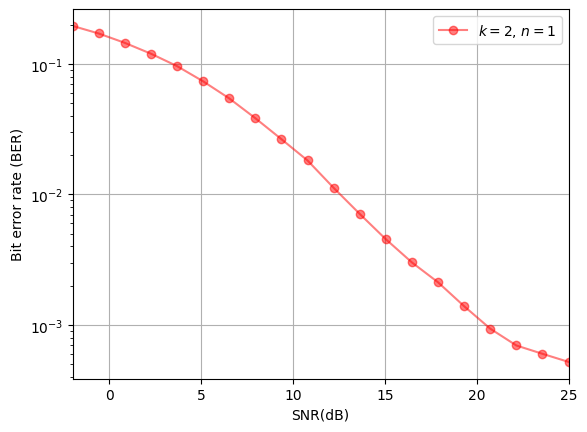

In [ ]:
tf.keras.backend.clear_session()# Resetting the name counters
# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# System Model Parameter--------------------------------------------------------
n = 1 # Codeword length
k = 2 # Number of information bits in each of the two messages
M = 2**k # Codebook size for each message
m_tx = 2 # Number of transmit antennas
m_rx = 2 # Number of receive antennas

# Creating and Training Tx and Rx Model=========================================
training_SNR_dB = 20
n_samples = 100_000
epochs = 30
batch_size = 1024
tx_model, ch_reyleigh, rx_model = MIMO_2by2_multiplexing(n = n, k = k, training_SNR_dB = training_SNR_dB, n_samples = n_samples, epochs = epochs, batch_size = batch_size)

# Evaluting BLER================================================================
n_samples_eval = 50_000
# Channel
H = tf.random.normal(shape = [n_samples_eval,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
# Messages----------------------------------------------------------------------
# Message indexing:
messages1 = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=M, dtype=tf.int32)
messages2 = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=M, dtype=tf.int32)
messages = np.concatenate((messages1, messages2), axis = 0)
# One-hot encoding:
X1 = tf.one_hot(messages1, M)# messages in the first input of Tx
X2 = tf.one_hot(messages2, M)# messages in the second input of Tx
# Iterating the values of Eb_N0-------------------------------------------------
SNR_num = 20
SNR_dB = np.linspace(-2,25,SNR_num)
BLER = np.zeros(SNR_num,)

for i in range(SNR_num):
  # Tx
  tx_signal = tx_model((X1,X2,H))

  # Rayleigh Channel
  ch_rayleigh_signal = ch_reyleigh((tx_signal,H))

  # AWGN
  snr = 10**(SNR_dB[i]/10)
  noise_std = np.sqrt(0.5/(snr))
  ch_out = ch_rayleigh_signal + tf.random.normal(shape=tf.shape(ch_rayleigh_signal), mean=0.0, stddev=noise_std)

  # Rx:
  X_hat1, X_hat2 = rx_model((ch_out,H))
  messages_hat1 = np.argmax(X_hat1, axis = -1)
  messages_hat2 = np.argmax(X_hat2, axis = -1)
  messages_hat = np.concatenate((messages_hat1, messages_hat2), axis = 0)
  # Counting the number of false prediction:------------------------------------
  BLER[i] = np.count_nonzero(messages_hat != messages) / (2*n_samples_eval)
  #print(BLER[i])

# BER Plot=====================================================================
# Assuming that an error in a block is most likely due to one bit of error, BER is approximated as BLER/k
BER_plot, = plt.plot(SNR_dB, BLER/k, 'r-o', label = r'$k=$' + f'{k}, ' + r'$n=$' + f'{n}')
BER_plot.set_alpha(0.5)
plt.legend(loc = 'best')
plt.xlabel("SNR(dB)")
plt.ylabel("Bit error rate (BER)")
plt.xlim([-2,25])
plt.yscale("log")
plt.grid()
plt.savefig(f"BLER_2by2MIMO.png")

The results of the simulation here is not as good as the learned curve represented in [2, Figure 7] for high SNRs, but it performs much better than the baseline in [2, Figure 7]. This difference can be due to the difference in:
-  Considerations for power normalization,
-  Deep learning architecture of encoder and decoder,
-  Training hyperparameters, and
-  Calculation of BER.

**Note:** Here, BER is not calculated. Rather, it is approximated by BLER divided by the number of bits in a message, which is based on the assumption that an error in a block is most likely due to one bit of error.


## Visualizing Codewords Constellations

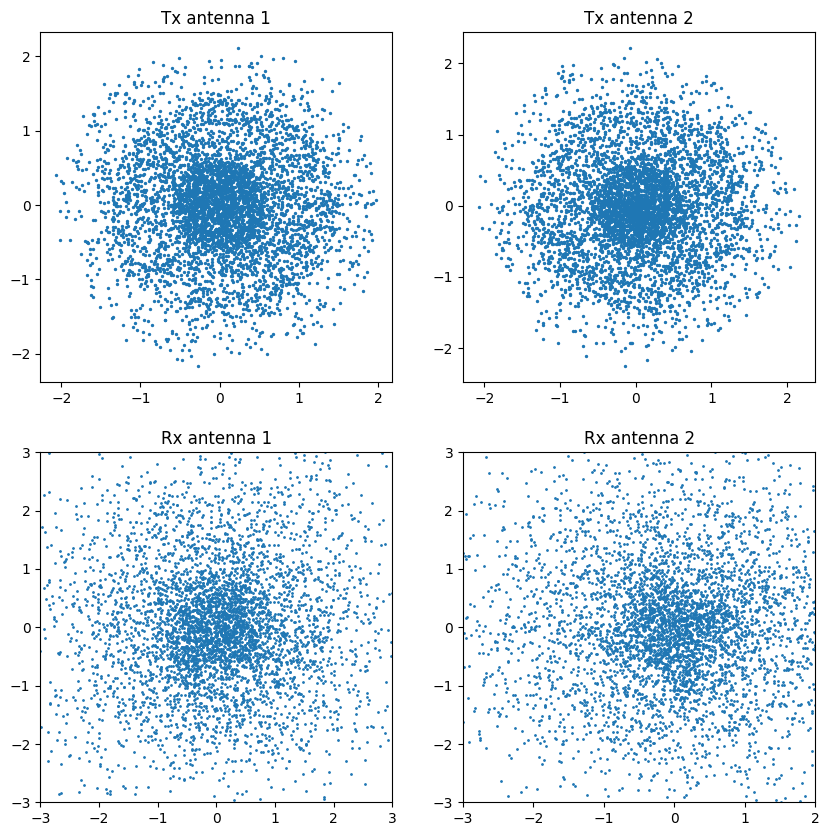

In [ ]:
# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# System Model Parameter--------------------------------------------------------
n = 1 # Codeword length
k = 2 # Number of information bits in each of the two messages
M = 2**k # Codebook size for each message
m_tx = 2 # Number of transmit antennas
m_rx = 2 # Number of receive antennas

SNR_dB_symbol = 20
snr = 10**(SNR_dB_symbol/10)
noise_std = np.sqrt(0.5/(snr))
n_symbols = 5_000

# Channel=======================================================================
H = tf.random.normal(shape = [n_symbols,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)

# Messages======================================================================
# Message indexing:
messages1 = tf.random.uniform(shape=(n_symbols,), minval=0, maxval=M, dtype=tf.int32)
messages2 = tf.random.uniform(shape=(n_symbols,), minval=0, maxval=M, dtype=tf.int32)

# One-hot encoding:
X_train1 = tf.one_hot(messages1, M)# messages in the first input of Tx
X_train2 = tf.one_hot(messages2, M)# messages in the second input of Tx

# Symbols=======================================================================
# Tx Symbols
tx_symbols = tx_model((X_train1,X_train2,H))
x1_real = tx_symbols[...,:n]
x1_complex = tx_symbols[...,n:2*n]
x2_real = tx_symbols[...,2*n:3*n]
x2_complex = tx_symbols[..., 3*n:4*n]

# Rx Symbols
rx_symbols = ch_reyleigh((tx_symbols,H))
rx_symbols = rx_symbols + tf.random.normal(shape = rx_symbols.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32)
y1_real = rx_symbols[...,:n]
y1_complex = rx_symbols[...,n:2*n]
y2_real = rx_symbols[...,2*n:3*n]
y2_complex = rx_symbols[..., 3*n:4*n]

# Plots=========================================================================
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.scatter(x1_real,x1_complex, s = 2)
#plt.xlim([-2,2])
#plt.ylim([-2,2])
plt.title('Tx antenna 1')
plt.subplot(2,2,2)
plt.scatter(x2_real,x2_complex, s = 2)
#plt.xlim([-2,2])
#plt.ylim([-2,2])
plt.title('Tx antenna 2')
plt.subplot(2,2,3)
plt.scatter(y1_real,y1_complex, s = 1)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title('Rx antenna 1')
plt.subplot(2,2,4)
plt.scatter(y2_real,y2_complex, s = 1)
plt.xlim([-3,2])
plt.ylim([-3,3])
plt.title('Rx antenna 2')
plt.savefig(f"Symbols_2by2MIMO.png")

In comparison to [2, Figure 8], in the symbols of the Tx antennas here, there is a kind of separation in power, which is not in [2, Figure 8]. In addition, the separation in the signals of Rx antennas in [2, Figure 8] does not appear here.

## Another Observation!

I observed that if I reduce the learning capacity of the transmitter by removing one of the hidden `Dense` layers, the constellation in Tx antennas become more like a QAM (Figure 3). I think during training, the transmitter learns both the statistical behavior of the channel and how to use channel matrix as an input. When I reduce the learning capacity of the transmitter, it seems that it mainly learns the statistical behavior of the channel rather than relying on the instantaneous channel matrix as an input.

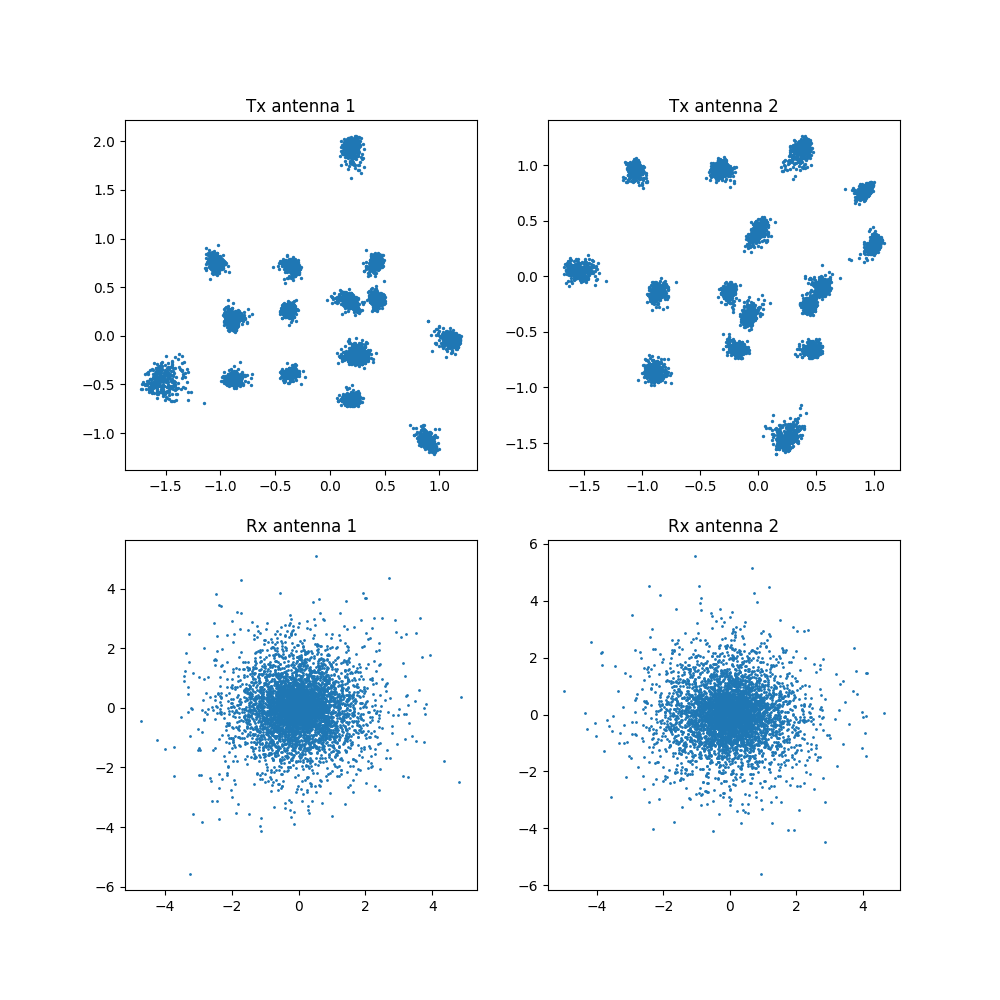

Figure 3: The result obtained by removing one of the hidden `Dense` layers of the transmitter.

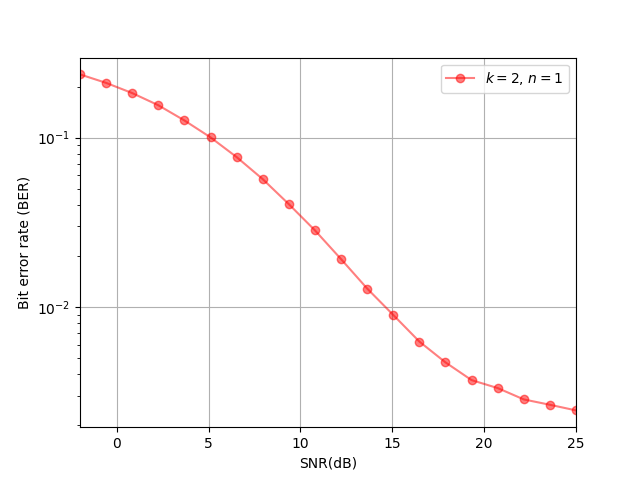

Figure 4: The BLER result obtained by removing one of the hidden `Dense` layers of the transmitter. It is not as good as the case that the transmitter has more capacity to learn.